In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Imbalance Handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 

# Models
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Evaluation
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

import shap

import warnings
warnings.filterwarnings('ignore')

In [2]:
modeling_data_path = 'final_modeling_data.csv'
df = pd.read_csv(modeling_data_path)

X = df.drop('acquired_within_1_year', axis=1)
y = df['acquired_within_1_year']

print("Data loaded.")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Data loaded.
Features shape: (31036, 10)
Target shape: (31036,)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 24828
Testing set size: 6208


In [4]:
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [5]:
lr_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
])

# Train the model
lr_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_pipeline.predict(X_test)
y_prob_lr = lr_pipeline.predict_proba(X_test)[:, 1]

print("--- Logistic Regression Evaluation ---")
print(classification_report(y_test, y_pred_lr))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob_lr):.4f}")

--- Logistic Regression Evaluation ---
              precision    recall  f1-score   support

           0       1.00      0.65      0.79      6194
           1       0.00      0.57      0.01        14

    accuracy                           0.65      6208
   macro avg       0.50      0.61      0.40      6208
weighted avg       1.00      0.65      0.78      6208

ROC AUC Score: 0.6348


In [6]:
xgb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Train the model
xgb_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_pipeline.predict(X_test)
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

print("--- XGBoost Evaluation ---")
print(classification_report(y_test, y_pred_xgb))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob_xgb):.4f}")

--- XGBoost Evaluation ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6194
           1       0.00      0.00      0.00        14

    accuracy                           0.99      6208
   macro avg       0.50      0.50      0.50      6208
weighted avg       1.00      0.99      0.99      6208

ROC AUC Score: 0.6600


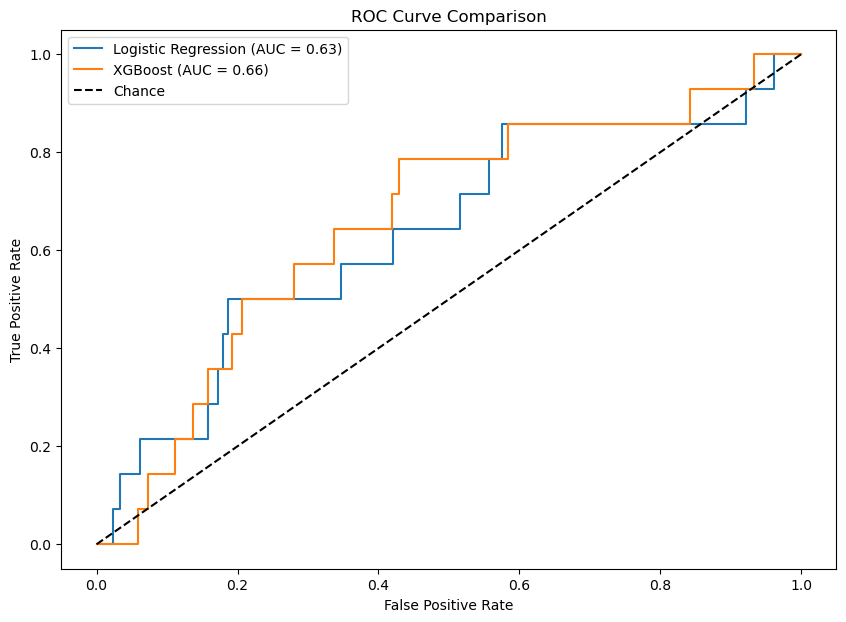

In [7]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_lr):.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_prob_xgb):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

In [8]:
# We need to get the feature names after one hot encoding for SHAP
onehot_cols = xgb_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = numerical_features + list(onehot_cols)

# Get the preprocessed training data
X_train_processed = pd.DataFrame(xgb_pipeline.named_steps['preprocessor'].transform(X_train).toarray(), columns=feature_names)

# Get the trained XGBoost model from the pipeline
model_xgb = xgb_pipeline.named_steps['classifier']

# Create SHAP explainer
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_train_processed)

print("SHAP values calculated.")

SHAP values calculated.


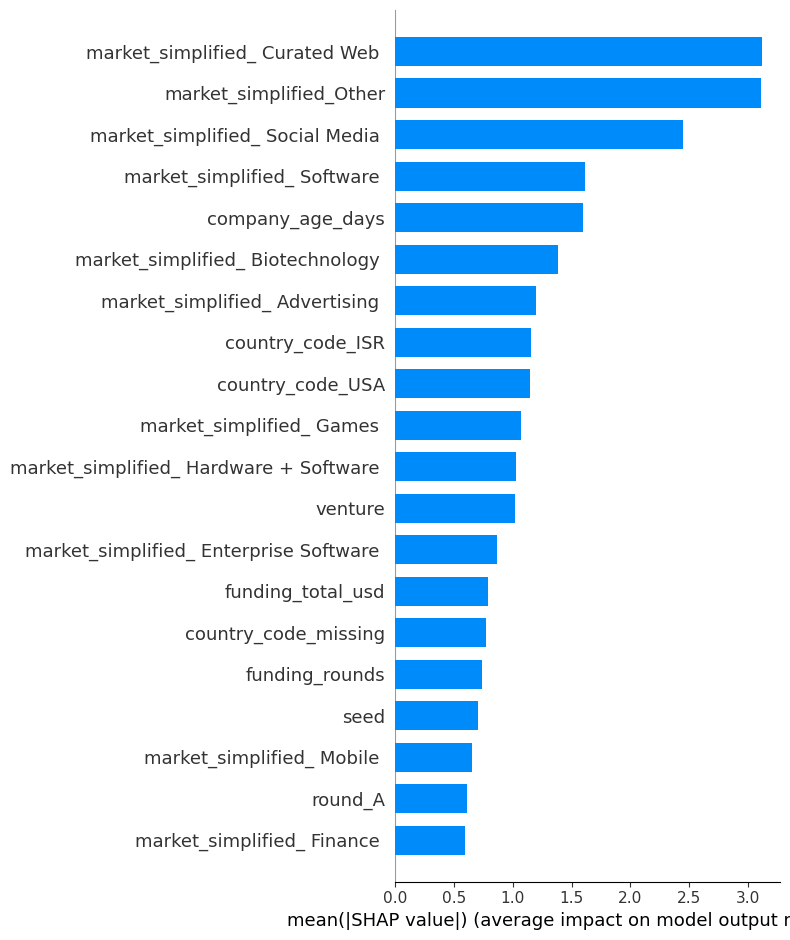

In [9]:
# SHAP Summary Plot (Bar)
shap.summary_plot(shap_values, X_train_processed, plot_type="bar")

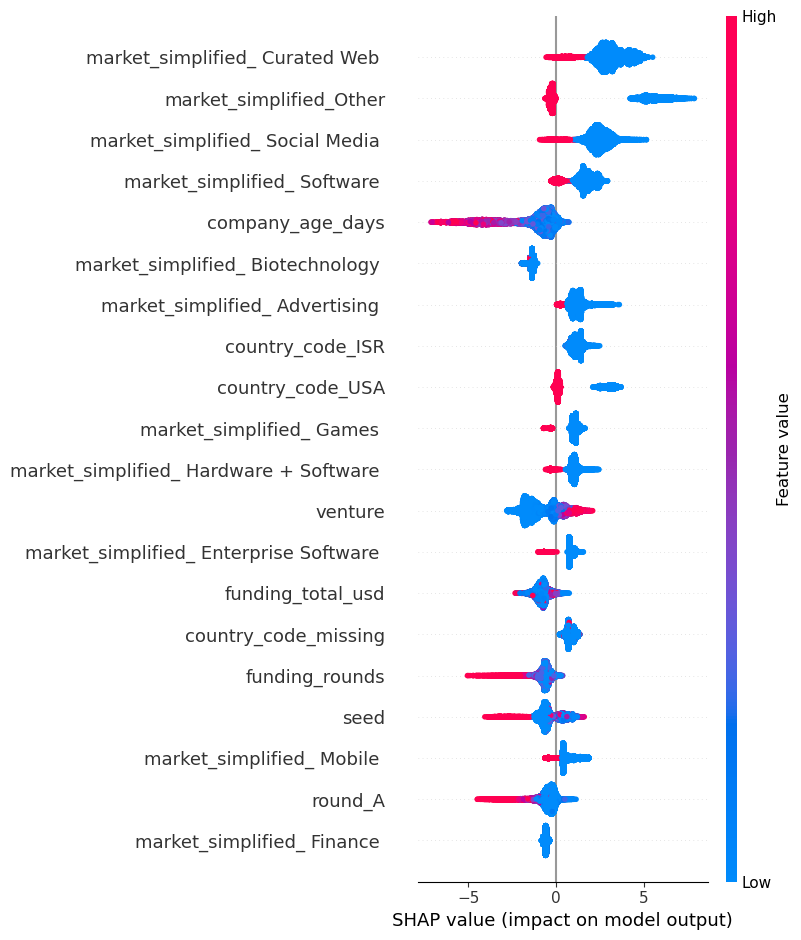

In [10]:
# SHAP Summary Plot (Dot)
shap.summary_plot(shap_values, X_train_processed)